In [1]:
import numpy as np
import pandas as pd
import random
import string

from sklearn.model_selection import ParameterSampler
from scipy.stats import randint as sp_randint
from scipy.stats import uniform, poisson

In [2]:
# city names
canada_cities = pd.read_csv('list-of-cities-in-canada-csv.csv',names=['city'])
canada_cities = list(canada_cities['city'])

#make of cars
car_make = [
    'honda',
    'toyota',
    'bmw',
    'mercedes',
    'ford',
    'gmc',
    'tesla',
    'chevy',
    'audi',
    'nissan',
    'acura',
]

model_dict = {
    'honda': ['civic', 'accord'],
    'toyota': ['camry', 'corrola'],
    'bmw': ['m3', 'i8', 'x5'],
    'mercedes': ['c', 's', 'g'],
    'ford': ['f150', 'focus', 'explorer'],
    'gmc': ['terrain','sierra','yukon'],
    'tesla': ['x', '3', 's'],
    'chevy': ['equinox', 'malibu'],
    'audi': ['r8','e-tron'],
    'nissan':['mirano','micro'],
    'acura':['rsx', 'mdx']
}


In [3]:
parameters = {'age':  sp_randint(18, 85),
              'city': canada_cities,
              'year': sp_randint(1998, 2020),
              'make': car_make,
              'dist': sp_randint(1200, 25000),
              'gender': ['m','f'],
              }

# other columns
    # new_used
    # model

p_list = list(ParameterSampler(parameters, n_iter=5000,random_state=32))

In [4]:
df = pd.DataFrame(p_list)
df

,age,city,dist,gender,make,year
0,61,Belleville,10726,m,audi,2017
1,21,Wood Buffalo,9401,m,toyota,2001
2,83,Kelowna,9427,m,acura,2016
3,28,St. John,21090,m,ford,2003
4,56,Sarnia,7099,m,audi,2018
...,...,...,...,...,...,...
4995,81,Lethbridge,11001,m,honda,2014
4996,46,Halifax,23018,m,ford,2005
4997,43,Montreal,2619,f,toyota,2003
4998,37,Laval,16457,m,mercedes,2017


In [5]:
def select_model_and_age(df, model_dict):
    model_list = []
    age_list = []
    
    for i in df.itertuples():
        if i.make in list(model_dict.keys()):
            model_ind = random.choice(model_dict[i.make])
            model_list.append(model_ind)
        else:
            model_list.append('other')
            
        if i.year > 2018:
            age_list.append('new')
        else:
            age_list.append('used')
            
        
    
        
            
    df['model'] = model_list
    df['new_used'] = age_list
    return df

In [6]:
df = select_model_and_age(df, model_dict)
df.head()

,age,city,dist,gender,make,year,model,new_used
0,61,Belleville,10726,m,audi,2017,e-tron,used
1,21,Wood Buffalo,9401,m,toyota,2001,camry,used
2,83,Kelowna,9427,m,acura,2016,mdx,used
3,28,St. John,21090,m,ford,2003,explorer,used
4,56,Sarnia,7099,m,audi,2018,e-tron,used


In [7]:
def insurance_price(df, base_rate, weights):
    weight_age = weights['weight_age']
    weight_city = weights['weight_city']
    weight_year = weights['weight_year']
    weight_make = weights['weight_make']
    weight_dist = weights['weight_dist']
    weight_gender = weights['weight_gender']
    rate_age = weights['rate_age']
    rate_make = weights['rate_make']
    rate_city = weights['rate_city']
    rate_year = weights['rate_year']
    rate_dist = weights['rate_dist']
    rate_gender = weights['rate_gender']
    
    # cost = base_rate + (weight_age * rate_age * age / 100) + weight_city * rate_city * category_cost+
    # weight_make * rate_make * category_cost + (weight_dist * dist * rate_dist)/1000 + 
    # weight_gender * rate_gender
    l = []
    for i in df.itertuples():
        # age buckets
        if i.age < 30:
            age_category_cost = 100
        elif i.age >=30 < 65:
            age_category_cost = 20
        elif i.age >=65 < 75:
            age_category_cost = 40
        else:
            age_category_cost = 120
        
        # city buckets
        city_index = string.ascii_lowercase.index(i.city[0].lower())
        if city_index < 10:
            city_category_cost = 10
        elif city_index >=10 < 17:
            city_category_cost = 50
        else:
            city_category_cost = 80
            
        
        # make buckets
        if i.make in ['honda', 'toyota','gmc','nissan','ford','chevy']:
            make_category_cost = 50
        elif i.make in ['acura', 'tesla']:
            make_category_cost = 90
        elif i.make in ['mercedes','bmw', 'audi']:
            make_category_cost = 140
        else:
            make_category_cost = 60
            
        # gender buckets
        if i.gender == 'm':
            gender_category_cost = 100
        else:
            gender_category_cost = 50
        
        # distance buckets
        if i.dist <3000:
            dist_category_cost = 50
        elif i.dist >=3000 < 8000:
            dist_category_cost = 100
        else:
            dist_category_cost = 160

            
        # calculation for making the cost
        cost_total = (base_rate + (weight_age * age_category_cost) ** rate_age  + (weight_city * city_category_cost) ** rate_city + (weight_make * make_category_cost) ** rate_make + (weight_dist * dist_category_cost) ** rate_dist + (weight_gender * gender_category_cost) ** rate_gender)/4
                
        l.append(cost_total/12.0)
    df2 = df.copy()
    df2['quote'] = l
    return df2

In [8]:
weight_params = {
    "weight_age": uniform(loc=0.8,scale=3),
    "weight_city": uniform(loc=0.5,scale=1.5),
    "weight_year": uniform(loc=0.4,scale=2),
    "weight_make": uniform(loc=0.9,scale=2),
    "weight_dist": uniform(loc=0.9,scale=1.5),
    "weight_gender": uniform(loc=0.9,scale=1.5),
    "rate_age": uniform(loc=0.9,scale=1.1),
    "rate_city": uniform(loc=0.9,scale=1.1),
    "rate_make": uniform(loc=0.9,scale=1.1),
    "rate_year": uniform(loc=0.9,scale=1.1),
    "rate_dist": uniform(loc=0.9,scale=1.1),
    "rate_gender": uniform(loc=0.9,scale=1.1),
}

weight_params_list = list(ParameterSampler(weight_params, n_iter=25,random_state=16))
weight_params_list[0:2]

[{'rate_age': 1.145620187068893,
  'rate_city': 1.4754796755407438,
  'rate_dist': 1.5057716022392993,
  'rate_gender': 0.950162145146087,
  'rate_make': 1.29680171888255,
  'rate_year': 1.1453890358604177,
  'weight_age': 2.8661784854640695,
  'weight_city': 0.7455971375013488,
  'weight_dist': 1.0054873002082505,
  'weight_gender': 2.311516290368754,
  'weight_make': 2.0273627604696505,
  'weight_year': 0.5559846787799742},
 {'rate_age': 1.694904562237324,
  'rate_city': 1.0742973908754831,
  'rate_dist': 1.1753094374184259,
  'rate_gender': 1.2228359817124173,
  'rate_make': 1.6662717856294544,
  'rate_year': 1.410690496844167,
  'weight_age': 1.4451864311430187,
  'weight_city': 1.1702393931194863,
  'weight_dist': 1.0813181273084354,
  'weight_gender': 2.2765305116170875,
  'weight_make': 2.032892657438391,
  'weight_year': 1.3440386314838544}]

In [9]:
df2 = insurance_price(df, 100, weight_params_list[2])
df2

,age,city,dist,gender,make,year,model,new_used,quote
0,61,Belleville,10726,m,audi,2017,e-tron,used,432.629987
1,21,Wood Buffalo,9401,m,toyota,2001,camry,used,175.000958
2,83,Kelowna,9427,m,acura,2016,mdx,used,263.333491
3,28,St. John,21090,m,ford,2003,explorer,used,175.000958
4,56,Sarnia,7099,m,audi,2018,e-tron,used,433.598257
...,...,...,...,...,...,...,...,...,...
4995,81,Lethbridge,11001,m,honda,2014,civic,used,169.286676
4996,46,Halifax,23018,m,ford,2005,focus,used,168.318406
4997,43,Montreal,2619,f,toyota,2003,corrola,used,93.659746
4998,37,Laval,16457,m,mercedes,2017,c,used,433.598257


In [10]:
l = []
index_counter = 0
for i in weight_params_list:
    df2 = insurance_price(df, 100, i)
    a = df2['quote'].to_numpy()
    name = 'company_{}.csv'.format(index_counter)
    df2.to_csv(name, index=False)
    l.append(a)
    index_counter += 1
    
l = np.array(l)
df3 = pd.DataFrame(l.T)

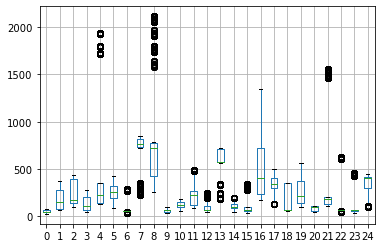

In [13]:
boxplot = df3.boxplot()

In [12]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,61.498395,285.602469,432.629987,202.331984,352.599790,289.107543,51.939949,810.230398,773.543820,69.066710,...,96.196944,721.756136,446.318300,351.875462,417.001041,102.931162,189.687505,62.517544,49.194721,313.225178
1,53.594907,166.203420,175.000958,116.671645,1723.855245,358.322171,286.095698,842.575260,2064.382346,88.103427,...,292.135624,855.265364,382.025653,68.318271,282.601189,103.238392,1539.214879,618.216661,448.953981,418.160493
2,51.645269,153.577825,263.333491,123.862127,221.792349,347.285672,56.319908,819.158314,750.891561,69.231271,...,69.759306,405.623289,378.892919,164.731811,256.853651,101.727820,194.263461,62.336643,61.772078,419.988166
3,53.594907,166.203420,175.000958,116.671645,1723.855245,358.322171,286.095698,842.575260,2064.382346,88.103427,...,292.135624,855.265364,382.025653,68.318271,282.601189,103.238392,1539.214879,618.216661,448.953981,418.160493
4,65.434111,286.959103,433.598257,223.778656,354.748787,391.203311,58.337741,821.113518,782.620440,71.330764,...,97.177385,722.424918,449.773993,353.440867,438.985571,103.279165,205.092982,65.064065,63.740799,435.972179
